In [112]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
pd.set_option('chained_assignment',None)
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sn
import ast
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [ ]:
# Data from: https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset

In [113]:
# read metadata file
df_meta = pd.read_csv('../Datasets/nasa/cleaned_dataset/metadata.csv')

# select battery ids of concern (5, 6, 7, 18)
df_meta = df_meta[(df_meta['battery_id'] == 'B0005') | (df_meta['battery_id'] == 'B0006')
               | (df_meta['battery_id'] == 'B0007') | (df_meta['battery_id'] == 'B0018')]
# df_meta = df_meta[df_meta['battery_id'] == 'B0006']
# df_meta.loc[(df_meta['battery_id'] == 'B0005') | (df_meta['battery_id'] == 'B0006')].head()
# df_meta = df_meta[(df_meta['battery_id'] == 'B0025') | (df_meta['battery_id'] == 'B0026')
#                | (df_meta['battery_id'] == 'B0027') | (df_meta['battery_id'] == 'B0028')|
#                (df_meta['battery_id'] == 'B0005') | (df_meta['battery_id'] == 'B0006')
#                | (df_meta['battery_id'] == 'B0007') | (df_meta['battery_id'] == 'B0018')]

In [114]:
# for each battery id, goal is to create lines for each "cycle" which encompasses a 'charge' and 'discharge' phase
# Steps:
    # create a remaining useful life (RUL) column which will be the difference between the cycle number and the total number of cycles
        # THIS WILL BE OUR DEPENDENT VARIABLE IN OUR MODELS
    # get impedance data for each line by back filling then forward filling 'Re' and 'Rct' columns
    # filter df where any 'type' is repeated in subsequent rows (sometimes a short 'bump' charge is performed after a full charge)
    # remove rows where type is 'impedance'
    # create a new column 'cycle' which will be the cycle number for each row (paired charge and discharge cycles)
    # create a new dataframe df_cycles which will contain information for each cycle

# new dataframe that will aggregate information for each 'cleaned' battery id data
df_0 = pd.DataFrame(columns=df_meta.columns)
# create a df_cycles for each charge/discharge cycle
df_cycles = pd.DataFrame(columns=['cycle', 'charge_file', 'discharge_file', 'RUL', 'pct_complete', 'Re', 'Rct', 'capacity'])

# helper function to generate df_cycles
def generate_cycles(cycle_id, type, filename, Re, Rct, capacity, df_cycles):
    # write filename for each cycle_id
    if type == 'charge':
        df_cycles.loc[cycle_id, 'charge_file'] = filename
    else:
        df_cycles.loc[cycle_id, 'discharge_file'] = filename
    # write cycle_id
    df_cycles.loc[cycle_id, 'cycle'] = cycle_id
    # write impedance values
    df_cycles.loc[cycle_id, 'Re'] = Re
    df_cycles.loc[cycle_id, 'Rct'] = Rct    
    # write capacity
    df_cycles.loc[cycle_id, 'capacity'] = capacity
    # write battery id
    df_cycles.loc[cycle_id, 'battery_id'] = batt

# iterate through each battery id
for batt in df_meta['battery_id'].unique():
    df_battery = df_meta[df_meta['battery_id'] == batt].copy()

    # write battery id
    df_battery['battery_id'] = batt

    # let's fill in the impedance values for each row 
    # backfill then forward fill 'Re' and 'Rct' columns
    df_battery['Re'] = df_battery['Re'].fillna(method='bfill').fillna(method='ffill')
    df_battery['Rct'] = df_battery['Rct'].fillna(method='bfill').fillna(method='ffill')
    
    # filter df where any 'type' is repeated in subsequent rows
    df_battery = df_battery.loc[df_battery['type'].shift() != df_battery['type'], :]
    # remove rows where type is 'impedance'
    df_battery = df_battery.loc[df_battery['type'] != 'impedance', :]

    # create a new column 'cycle' which will be the cycle number for each row (paired charge and discharge cycles)
    df_battery['cycle'] = 0
    df_battery['cycle'] = np.where(df_battery['type'] == 'charge', 1, 0)
    df_battery['cycle'] = df_battery['cycle'].cumsum()
    
    # append to df_0
    df_0 = df_0.append(df_battery, ignore_index=True)

    # dataframe to store each cycle for a given battery id
    df_cycles_batt = pd.DataFrame(columns=df_cycles.columns)

    # populate df_cycles_batt
    df_battery.apply(lambda x: generate_cycles(x['cycle'], x['type'], x['filename'], x['Re'], x['Rct'], 
                                               x['Capacity'], df_cycles_batt), axis=1)
    
    # drop rows where charge isn't paired with a discharge (either one is NAN)
    df_cycles_batt['RUL'] = 0
    df_cycles_batt['pct_complete'] = 0
    df_cycles_batt = df_cycles_batt.dropna()

    # adjust dtypes
    df_cycles_batt = df_cycles_batt.infer_objects()
    # change Re, Rct and capacity to float
    df_cycles_batt['Re'] = df_cycles_batt['Re'].astype('float')
    df_cycles_batt['Rct'] = df_cycles_batt['Rct'].astype('float')
    df_cycles_batt['capacity'] = df_cycles_batt['capacity'].astype('float')    

    # get rid of any rows where discharge is complete (battery at EOL of < 1.4 Ah)
    df_cycles_batt = df_cycles_batt.loc[df_cycles_batt['capacity'] > 1.4, :]
    # get rid of spurious rows for battery 7 (files 06348.csv and 06350.csv)
    df_cycles_batt = df_cycles_batt[(df_cycles_batt['discharge_file'] != '06348.csv') 
                                    & (df_cycles_batt['discharge_file'] != '06350.csv')]

    # renumber cycles starting at 1
    df_cycles_batt['cycle'] = np.arange(1, len(df_cycles_batt) + 1)

    # calculate RUL for each cycle
    df_cycles_batt['RUL'] = len(df_cycles_batt) - df_cycles_batt['cycle'] + 1

    # calculate percent complete for each battery cycle
    df_cycles_batt['pct_complete'] = df_cycles_batt['cycle'] / len(df_cycles_batt)

    # append to df_cycles
    df_cycles = df_cycles.append(df_cycles_batt, ignore_index=True)

df_cycles 

,cycle,charge_file,discharge_file,RUL,pct_complete,Re,Rct,capacity,battery_id
0,1,04505.csv,04506.csv,108,0.009259,0.061234,0.078542,2.035338,B0006
1,2,04507.csv,04508.csv,107,0.018519,0.061234,0.078542,2.025140,B0006
2,3,04509.csv,04510.csv,106,0.027778,0.061234,0.078542,2.013326,B0006
3,4,04511.csv,04512.csv,105,0.037037,0.061234,0.078542,2.013285,B0006
4,5,04513.csv,04514.csv,104,0.046296,0.061234,0.078542,2.000528,B0006
...,...,...,...,...,...,...,...,...,...
495,100,06616.csv,06617.csv,5,0.961538,0.066025,0.089397,1.428368,B0018
496,101,06618.csv,06619.csv,4,0.971154,0.066025,0.089397,1.414787,B0018
497,102,06621.csv,06622.csv,3,0.980769,0.065289,0.091392,1.413889,B0018
498,103,06645.csv,06646.csv,2,0.990385,0.065219,0.090349,1.426843,B0018


In [115]:
# for each cycle:
# read charge and discharge csv files
# write columns to df_cycles for charge_current, charge_voltage, charge_time, discharge_current, discharge_voltage, discharge_time

# helper function to read csv files and write to df_cycles
def get_data(charge_file, discharge_file, cycle_id, df_cycles):
    # read charge csv file
    df_charge = pd.read_csv(f'''../Datasets/nasa/cleaned_dataset/data/{charge_file}''')
    # read discharge csv file
    df_discharge = pd.read_csv(f'''../Datasets/nasa/cleaned_dataset/data/{discharge_file}''')

    # clean the df_charge
    # delete rows where the charge is complete ('Current_charge' <= 0)
    df_charge = df_charge.loc[df_charge['Current_charge'] > 0.009, :]
    # only write to df_cycles if charge performed from fully discharged state 
    # (first row  of df_charge['Voltage_measured'] <= 3.95)
    if df_charge['Voltage_measured'].tolist()[0] <= 3.85:        
        df_cycles.at[cycle_id, 'charge_current'] = df_charge['Current_measured'].tolist()
        df_cycles.at[cycle_id, 'charge_voltage'] = df_charge['Voltage_measured'].tolist()
        df_cycles.at[cycle_id, 'charge_voltage_shape'] = df_charge.loc[df_charge['Current_measured'] > 1.48, 'Voltage_measured'].tolist()
        df_cycles.at[cycle_id, 'charge_temp'] = df_charge['Temperature_measured'].tolist()
        df_cycles.at[cycle_id, 'charge_time'] = df_charge['Time'].tolist()
    
    # clean the df_discharge
    # delete rows where the discharge is not occuring ('Current_Measured' >= -1.5)
    df_discharge = df_discharge.loc[df_discharge['Current_measured'] < -1.5, :]

    df_cycles.at[cycle_id, 'discharge_current'] = df_discharge['Current_measured'].tolist()
    df_cycles.at[cycle_id, 'discharge_voltage'] = df_discharge['Voltage_measured'].tolist()
    df_cycles.at[cycle_id, 'discharge_temp'] = df_discharge['Temperature_measured'].tolist()
    df_cycles.at[cycle_id, 'discharge_time'] = df_discharge['Time'].tolist()

    return df_cycles

# create columns for new data
df_cycles.loc[:,'charge_current'] = None
df_cycles.loc[:,'charge_voltage'] = None
df_cycles.loc[:,'charge_voltage_shape'] = None
df_cycles.loc[:, 'charge_temp'] = None
df_cycles.loc[:,'charge_time'] = None
df_cycles.loc[:,'discharge_current'] = None
df_cycles.loc[:,'discharge_voltage'] = None
df_cycles.loc[:, 'discharge_temp'] = None
df_cycles.loc[:,'discharge_time'] = None

# apply function to each row df_cycles
for i in df_cycles.index:
    # print(i)
    df_cycles = get_data(df_cycles.loc[i, 'charge_file'], df_cycles.loc[i, 'discharge_file'], i, df_cycles)

# drop any incomplete cycles
df_cycles = df_cycles.dropna()

df_cycles


,cycle,charge_file,discharge_file,RUL,pct_complete,Re,Rct,capacity,battery_id,charge_current,charge_voltage,charge_voltage_shape,charge_temp,charge_time,discharge_current,discharge_voltage,discharge_temp,discharge_time
1,2,04507.csv,04508.csv,107,0.018519,0.061234,0.078542,2.025140,B0006,"[1.5155946354755825, 1.514882903277245, 1.5154...","[3.3202491629293425, 3.344726751731993, 3.3614...","[3.3202491629293425, 3.344726751731993, 3.3614...","[31.861155418610604, 31.85843990236285, 31.836...","[5.5, 8.390999999999998, 11.265999999999998, 1...","[-2.011916321449145, -2.009224769583939, -2.01...","[3.9699234098950793, 3.9497756291886352, 3.934...","[24.70686080461703, 24.851564341312493, 25.035...","[35.703, 53.828, 71.891, 90.047, 108.313, 126...."
2,3,04509.csv,04510.csv,106,0.027778,0.061234,0.078542,2.013326,B0006,"[1.5144197359530571, 1.5142914622821508, 1.514...","[3.327555903644184, 3.3513477668415503, 3.3675...","[3.327555903644184, 3.3513477668415503, 3.3675...","[32.149172607204065, 32.135697532465585, 32.11...","[5.546999999999997, 8.390999999999998, 11.281,...","[-2.01128469330264, -2.0106077477887023, -2.01...","[3.97271166774224, 3.952874422582056, 3.937513...","[24.769319436472557, 24.920004066730268, 25.09...","[35.766, 53.891, 72.094, 90.187, 108.328, 126...."
3,4,04511.csv,04512.csv,105,0.037037,0.061234,0.078542,2.013285,B0006,"[1.5124923153850145, 1.5143972479928318, 1.513...","[3.3764405727061044, 3.3979998760008376, 3.412...","[3.3764405727061044, 3.3979998760008376, 3.412...","[32.01707420321111, 32.00869468297801, 31.9821...","[5.453000000000003, 8.296, 11.14, 14.0, 16.828...","[-2.012496196247783, -2.010646327219511, -2.00...","[3.974101871052972, 3.9542219188259016, 3.9389...","[24.715600194800057, 24.853761873618037, 25.01...","[35.75, 53.813, 72.047, 90.219, 108.375, 126.5..."
4,5,04513.csv,04514.csv,104,0.046296,0.061234,0.078542,2.000528,B0006,"[1.5144257696345642, 1.5142867035877798, 1.514...","[3.407327679179539, 3.427771234730257, 3.44224...","[3.407327679179539, 3.427771234730257, 3.44224...","[31.92107046426389, 31.91287499609288, 31.8919...","[5.453000000000003, 8.280999999999999, 11.14, ...","[-2.0126597030736986, -2.008472082175145, -2.0...","[3.974047340293299, 3.953890355170001, 3.93902...","[24.69769974758998, 24.84835745433914, 24.9875...","[35.656000000000006, 53.859, 72.0, 90.156, 108..."
5,6,04515.csv,04516.csv,103,0.055556,0.061234,0.078542,2.013899,B0006,"[1.5153382990824429, 1.5149242271762446, 1.514...","[3.3915543191215747, 3.4132673012457104, 3.428...","[3.3915543191215747, 3.4132673012457104, 3.428...","[32.03239363568571, 32.01105799913918, 31.9920...","[5.453000000000003, 8.313000000000002, 11.1880...","[-2.0106851709069407, -2.0120389642947645, -2....","[3.988512647832949, 3.9680023455224185, 3.9523...","[24.42616165221062, 24.56604978266755, 24.7295...","[35.703, 53.906, 71.953, 90.11, 108.25, 126.25..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,100,06616.csv,06617.csv,5,0.961538,0.066025,0.089397,1.428368,B0018,"[1.516576364552476, 1.5145388263268844, 1.5169...","[3.534423522331462, 3.588279305438125, 3.61749...","[3.534423522331462, 3.588279305438125, 3.61749...","[33.6278614961481, 33.6204857588157, 33.572642...","[8.780999999999999, 14.936999999999998, 21.14,...","[-2.007585175150695, -2.007260326499711, -2.00...","[3.977410448953089, 3.950463883962789, 3.93096...","[23.371016250951325, 23.468204240916528, 23.59...","[24.0, 37.813, 51.672, 65.547, 79.344, 93.125,..."
496,101,06618.csv,06619.csv,4,0.971154,0.066025,0.089397,1.414787,B0018,"[1.5163558950403544, 1.5157881593747662, 1.518...","[3.544804525152861, 3.5987665949165044, 3.6279...","[3.544804525152861, 3.5987665949165044, 3.6279...","[33.455970714781486, 33.45512171142989, 33.396...","[8.796999999999997, 14.984000000000002, 21.187...","[-2.0073405689961543, -2.0076153829896666, -2....","[3.973701984751137, 3.947464496233271, 3.92833...","[23.08345031545013, 23.181876925432302

In [116]:
# ###### UNCLEANED VERSION FOR PPT DEMONSTRATION ####

# # for each cycle:
# # read charge and discharge csv files
# # write columns to df_cycles for charge_current, charge_voltage, charge_time, discharge_current, discharge_voltage, discharge_time

# # helper function to read csv files and write to df_cycles
# def get_data(charge_file, discharge_file, cycle_id, df_cycles):
#     # read charge csv file
#     df_charge = pd.read_csv(f'''../Datasets/nasa/cleaned_dataset/data/{charge_file}''')
#     # read discharge csv file
#     df_discharge = pd.read_csv(f'''../Datasets/nasa/cleaned_dataset/data/{discharge_file}''')

#     # clean the df_charge
#     # delete rows where the charge is complete ('Current_charge' <= 0)
#     # df_charge = df_charge.loc[df_charge['Current_charge'] > 0.009, :]
#     # only write to df_cycles if charge performed from fully discharged state 
#     # (first row  of df_charge['Voltage_measured'] <= 3.95)
#     # if df_charge['Voltage_measured'].tolist()[0] <= 3.95:        
#     # write charge_current, charge_voltage, charge_temp, charge_time, 
#     # discharge_current, discharge_voltage, discharge_temp, discharge_time
#     df_cycles.at[cycle_id, 'charge_current'] = df_charge['Current_measured'].tolist()
#     df_cycles.at[cycle_id, 'charge_voltage'] = df_charge['Voltage_measured'].tolist()
#     df_cycles.at[cycle_id, 'charge_temp'] = df_charge['Temperature_measured'].tolist()
#     df_cycles.at[cycle_id, 'charge_time'] = df_charge['Time'].tolist()
    
#     # clean the df_discharge
#     # delete rows where the discharge is not occuring ('Current_Measured' >= -1.5)
#     # df_discharge = df_discharge.loc[df_discharge['Current_measured'] < -1.5, :]
#     # write rows to df_discharge
#     df_cycles.at[cycle_id, 'discharge_current'] = df_discharge['Current_measured'].tolist()
#     df_cycles.at[cycle_id, 'discharge_voltage'] = df_discharge['Voltage_measured'].tolist()
#     df_cycles.at[cycle_id, 'discharge_temp'] = df_discharge['Temperature_measured'].tolist()
#     df_cycles.at[cycle_id, 'discharge_time'] = df_discharge['Time'].tolist()

#     return df_cycles

# # create columns for charge_current, charge_voltage, charge_time, discharge_current, discharge_voltage, discharge_time
# # as dtype object to store lists
# df_cycles.loc[:,'charge_current'] = None
# df_cycles.loc[:,'charge_voltage'] = None
# df_cycles.loc[:, 'charge_temp'] = None
# df_cycles.loc[:,'charge_time'] = None
# df_cycles.loc[:,'discharge_current'] = None
# df_cycles.loc[:,'discharge_voltage'] = None
# df_cycles.loc[:, 'discharge_temp'] = None
# df_cycles.loc[:,'discharge_time'] = None

# # apply function to each row df_cycles
# for i in df_cycles.index:
#     # print(i)
#     df_cycles = get_data(df_cycles.loc[i, 'charge_file'], df_cycles.loc[i, 'discharge_file'], i, df_cycles)

# # drop any incomplete cycles
# df_cycles = df_cycles.dropna()

# df_cycles


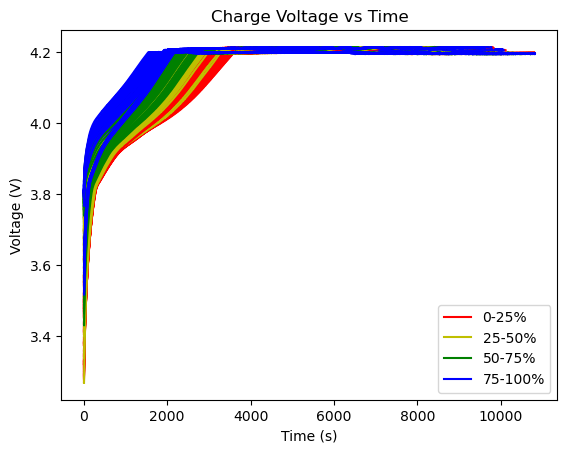

In [117]:
# plot the charge voltage vs time for every cycle 

fig, ax = plt.subplots()
colors = ['r', 'y', 'g', 'b']
for i in df_cycles.index:
    # print(i)
    if df_cycles.loc[i, 'pct_complete'] <= 0.25:
        ax.plot(df_cycles.loc[i, 'charge_time'], df_cycles.loc[i, 'charge_voltage'], color=colors[0])
    elif df_cycles.loc[i, 'pct_complete'] <= 0.50:
        ax.plot(df_cycles.loc[i, 'charge_time'], df_cycles.loc[i, 'charge_voltage'], color=colors[1])
    elif df_cycles.loc[i, 'pct_complete'] <= 0.75:
        ax.plot(df_cycles.loc[i, 'charge_time'], df_cycles.loc[i, 'charge_voltage'], color=colors[2])
    else:
        ax.plot(df_cycles.loc[i, 'charge_time'], df_cycles.loc[i, 'charge_voltage'], color=colors[3])

ax.plot([],[], color=colors[0], label='0-25%')
ax.plot([],[], color=colors[1], label='25-50%')
ax.plot([],[], color=colors[2], label='50-75%')
ax.plot([],[], color=colors[3], label='75-100%')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Charge Voltage vs Time')
plt.show()




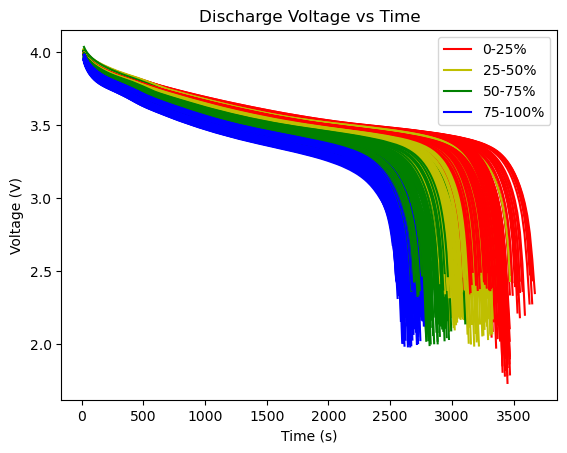

In [118]:
# plot the discharge voltage vs time for every cycle
 
fig, ax = plt.subplots()
colors = ['r', 'y', 'g', 'b']
for i in df_cycles.index:
    # print(i)
    if df_cycles.loc[i, 'pct_complete'] <= 0.25:
        ax.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_voltage'], color=colors[0])
    elif df_cycles.loc[i, 'pct_complete'] <= 0.50:
        ax.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_voltage'], color=colors[1])
    elif df_cycles.loc[i, 'pct_complete'] <= 0.75:
        ax.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_voltage'], color=colors[2])
    else:
        ax.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_voltage'], color=colors[3])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Discharge Voltage vs Time')

ax.plot([],[], color=colors[0], label='0-25%')
ax.plot([],[], color=colors[1], label='25-50%')
ax.plot([],[], color=colors[2], label='50-75%')
ax.plot([],[], color=colors[3], label='75-100%')
ax.legend()
plt.show()

    

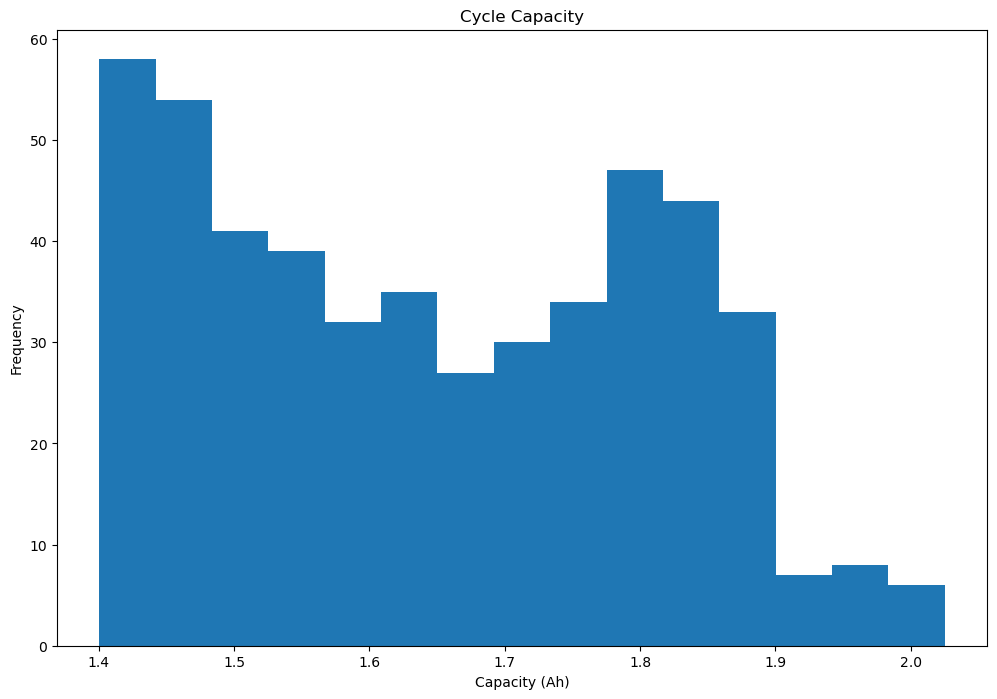

In [119]:
# histogram of cycle capacity
plt.figure(figsize=(12,8))
plt.hist(df_cycles['capacity'].astype('float').tolist(), bins=15)
plt.title('Cycle Capacity')
plt.xlabel('Capacity (Ah)')
plt.ylabel('Frequency')
plt.show()

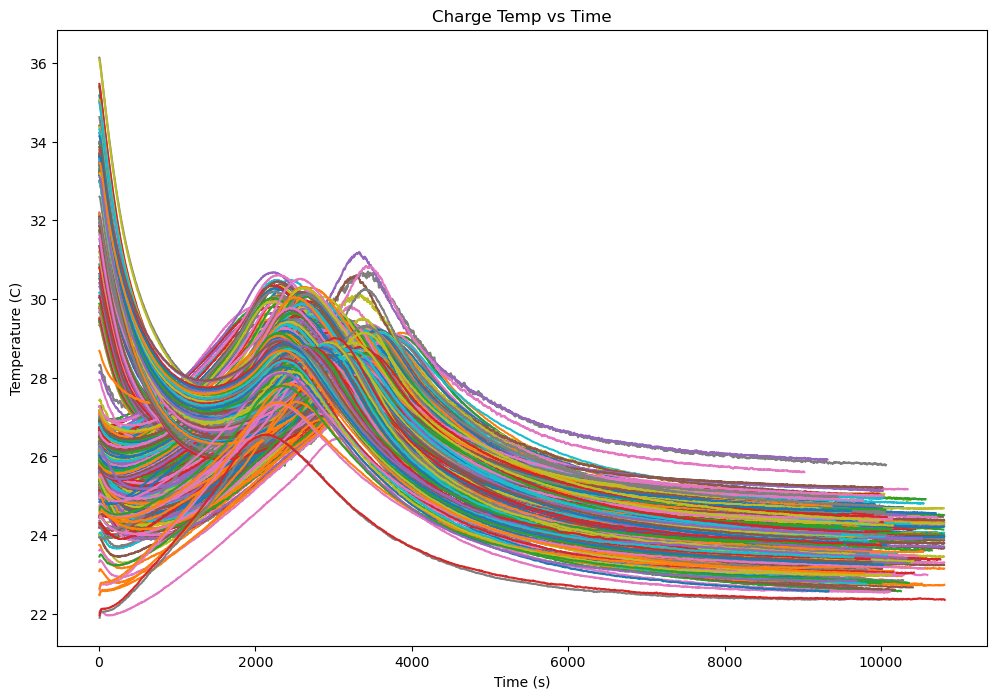

In [120]:
# charge temp over time
plt.figure(figsize=(12,8))
for i in df_cycles.index:
    plt.plot(df_cycles.loc[i, 'charge_time'], df_cycles.loc[i, 'charge_temp'])
plt.title('Charge Temp vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

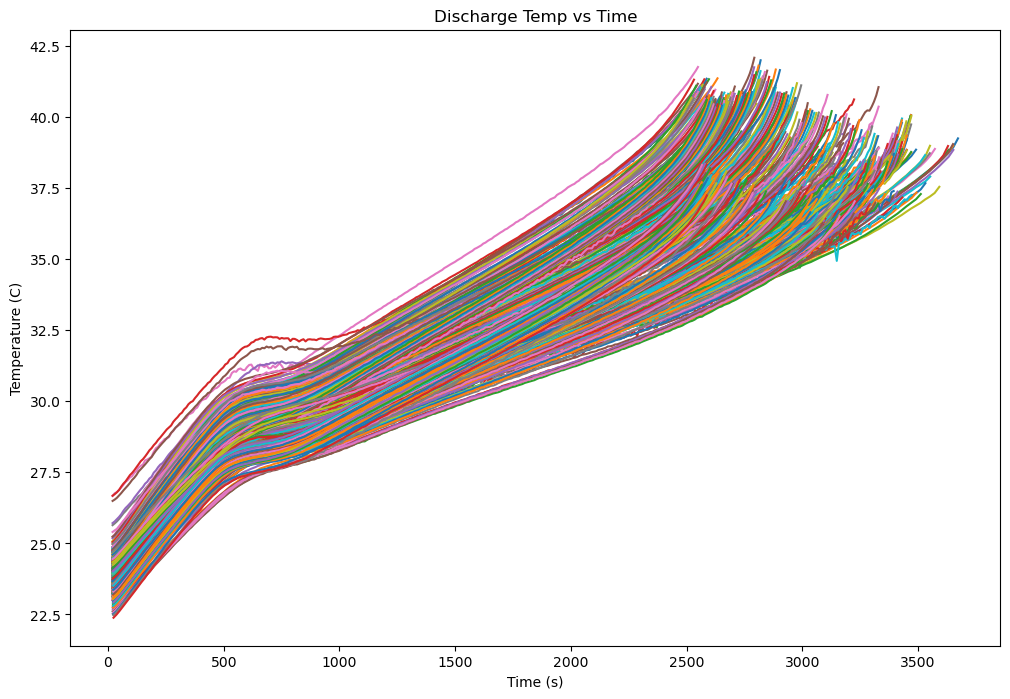

In [121]:
# discharge temp over time
plt.figure(figsize=(12,8))
for i in df_cycles.index:
    plt.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_temp'])
plt.title('Discharge Temp vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.show()

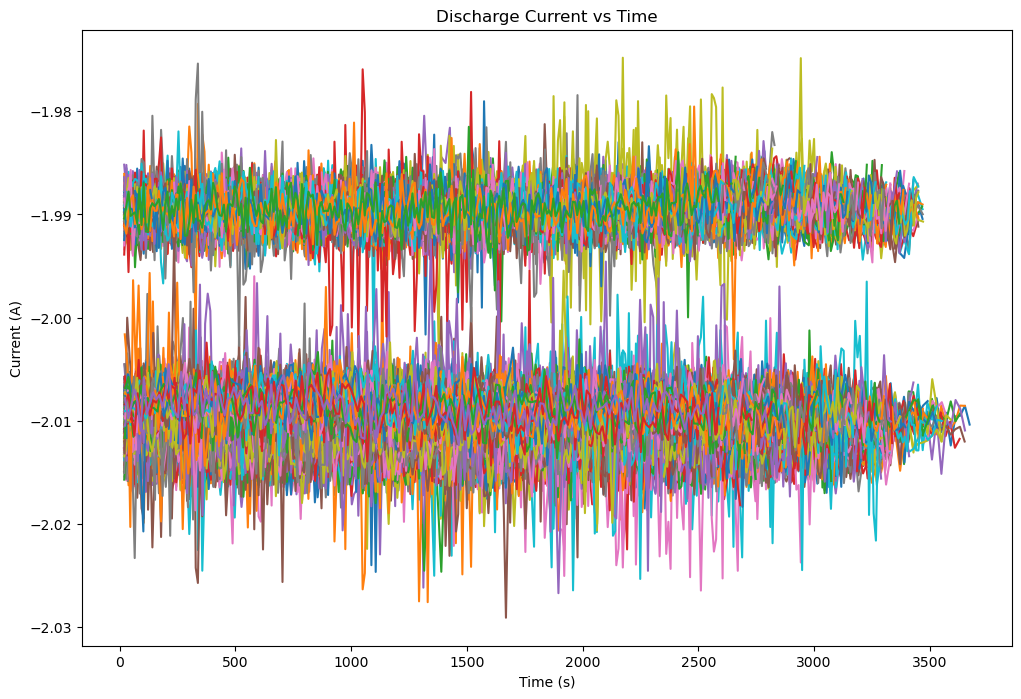

In [122]:
# std deviation of discharge current vs time 
plt.figure(figsize=(12,8))
for i in df_cycles.index:
    plt.plot(df_cycles.loc[i, 'discharge_time'], df_cycles.loc[i, 'discharge_current']) 
plt.title('Discharge Current vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.show()


In [123]:
# now let's get some characteristics of the charge and discharge cycles
# for the charge:
    # we want to know how long it takes to charge the battery. This will be done in two parts:
        # 1. the time it takes to charge the battery to 42.V
        # 2. the time it takes to complete the constant current phase of the charge
    # we also want to know the temperature rise during the charge

# for the discharge:
    # we want to know the maximum and average temperature
    # standard deviation of discharge_current

# function to get cycle characteristics
def cycle_characteristics(df_cycles):

    # add new columns to df_cycles
    df_cycles.loc[:,'charge_time_0'] = None
    df_cycles.loc[:,'charge_time_1'] = None
    df_cycles.loc[:,'charge_temp_gain'] = None
    df_cycles.loc[:,'discharge_max_temp'] = None
    df_cycles.loc[:,'discharge_avg_temp'] = None
    df_cycles.loc[:,'discharge_current_std'] = None

    # coefficients for the charge curve
    df_cycles.loc[:,'L_charge'] = None
    df_cycles.loc[:,'x0_charge'] = None
    df_cycles.loc[:,'k_charge'] = None
    df_cycles.loc[:,'b_charge'] = None

    # coefficients for the actual discharge curve 
    df_cycles.loc[:,'L_discharge'] = None
    df_cycles.loc[:,'x0_discharge'] = None
    df_cycles.loc[:,'k_discharge'] = None
    df_cycles.loc[:,'b_discharge'] = None

    # coefficients for the simulated discharge curve
    df_cycles.loc[:,'L_discharge_sim'] = None
    df_cycles.loc[:,'x0_discharge_sim'] = None
    df_cycles.loc[:,'k_discharge_sim'] = None
    df_cycles.loc[:,'b_discharge_sim'] = None

    # simulated discharge voltage and time
    # df_cycles.loc[:, 'discharge_voltage_sim'] = None
    # df_cycles.loc[:, 'discharge_time_sim'] = None
    np.random.seed(0)
    df_cycles.loc[:, 'discharge_state'] = np.random.randint(10,40,len(df_cycles))

    # apply to each row of df_cycles
    for x in df_cycles.index:
        # get charge and discharge data
        charge_time = df_cycles.loc[x, 'charge_time']
        charge_voltage = df_cycles.loc[x, 'charge_voltage']
        charge_current = df_cycles.loc[x, 'charge_current']
        charge_temp = df_cycles.loc[x, 'charge_temp']
        discharge_time = df_cycles.loc[x, 'discharge_time']
        discharge_temp = df_cycles.loc[x, 'discharge_temp']
        discharge_current = df_cycles.loc[x, 'discharge_current']
        # filter down discharge voltage/time based on discharge state
        # print(list(df_cycles.loc[x, 'discharge_voltage'])[:int(df_cycles.loc[x, 'discharge_state'])])
        # df_cycles.loc[x, 'discharge_voltage_sim'] = list(df_cycles.loc[x, 'discharge_voltage'])[:int(df_cycles.loc[x, 'discharge_state'])]
        # df_cycles.loc[x, 'discharge_time_sim'] = list(df_cycles.loc[x, 'discharge_time'])[:int(df_cycles.loc[x, 'discharge_state'])]

        # battery id
        batt = df_cycles.loc[x, 'battery_id']

        #### charge characteristics ####

        # battery is considered fully charged at 4.2V
        # split charge_voltage into two lists: one for voltage < 4.2 and one for voltage > 4.2
        # set flags for when voltage crosses 4.2V
        flag_ind = 0
        for i in range(len(charge_voltage)):
            if charge_voltage[i] >= 4.2:
                flag_ind = i
                break
        # calculate time to charge to 4.2V
        charge_time_0 = charge_time[flag_ind] - charge_time[0]  
        # calculate time to complete constant current phase
        charge_time_1 = charge_time[-1] - charge_time[flag_ind]
        # temperature rise during charge until constant current phase
        charge_temp_gain = charge_temp[flag_ind] - charge_temp[0]

        # setup x and y for curve fitting
        y_charge = df_cycles.loc[x, 'charge_voltage_shape']
        X_charge = charge_time[:len(y_charge)]
        X_charge = np.array(X_charge).reshape(-1,1)
        y_charge = np.array(y_charge).reshape(-1,1)
        # print(X_charge.shape, y_charge.shape)
        
        # reference for assistance in implementing sigmoid function (no snippets copied, only reference used)
        # https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python    
        # implementation of curve_fit()
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

        def sigmoid(x, L ,x0, k, b):
            y = L / (1 + np.exp(-k*(x-x0)))+b
            return y

        X_charge = X_charge.flatten()
        y_charge = y_charge.flatten()

        # initial guess for curve fitting
        p0 = [max(X_charge), np.median(y_charge),1,min(X_charge)]
        
        popt, pcov = curve_fit(sigmoid, y_charge, X_charge, p0=p0, method='lm')
        L_charge = popt[0]
        x0_charge = popt[1]
        k_charge = popt[2]
        b_charge = popt[3]

        # write to df_cycles
        df_cycles.loc[x, 'charge_time_0'] = charge_time_0
        df_cycles.loc[x, 'charge_time_1'] = charge_time_1
        df_cycles.loc[x, 'charge_temp_gain'] = charge_temp_gain
        df_cycles.loc[x, 'L_charge'] = L_charge
        df_cycles.loc[x, 'x0_charge'] = x0_charge
        df_cycles.loc[x, 'k_charge'] = k_charge
        df_cycles.loc[x, 'b_charge'] = b_charge

        #### discharge characteristics ####

        # calculate maximum and average temperature
        discharge_max_temp = max(discharge_temp)
        discharge_avg_temp = sum(discharge_temp)/len(discharge_temp)

        # standard deviation of discharge_current
        discharge_current_std = np.std(discharge_current)

        # setup x and y for curve fitting
        X_discharge = np.array(df_cycles.loc[x, 'discharge_voltage'])
        y_discharge = np.array(discharge_time)
        
        p0 = [max(y_discharge), np.median(X_discharge),1,min(y_discharge)] 
        popt, pcov = curve_fit(sigmoid, X_discharge.flatten(), y_discharge.flatten(), p0=p0, method='lm')
        L_discharge = popt[0]
        x0_discharge = popt[1]
        k_discharge = popt[2]
        b_discharge = popt[3]

        # write to df_cycles
        df_cycles.loc[x, 'discharge_max_temp'] = discharge_max_temp
        df_cycles.loc[x, 'discharge_avg_temp'] = discharge_avg_temp
        df_cycles.loc[x, 'discharge_current_std'] = discharge_current_std
        df_cycles.loc[x, 'L_discharge'] = L_discharge
        df_cycles.loc[x, 'x0_discharge'] = x0_discharge
        df_cycles.loc[x, 'k_discharge'] = k_discharge
        df_cycles.loc[x, 'b_discharge'] = b_discharge
    
    L_discharge_max, L_discharge_min = max(df_cycles['L_discharge'])*1.5, min(df_cycles['L_discharge'])*0.5
    x0_discharge_max, x0_discharge_min = max(df_cycles['x0_discharge'])*1.5, min(df_cycles['x0_discharge'])*0.5
    k_discharge_max, k_discharge_min = max(df_cycles['k_discharge'])*1.5, min(df_cycles['k_discharge'])*0.5
    b_discharge_max, b_discharge_min = max(df_cycles['b_discharge'])*1.5, min(df_cycles['b_discharge'])*0.5

    # set bounds for curve fitting
    bounds = ([L_discharge_min, x0_discharge_min, k_discharge_min, b_discharge_min],
                [L_discharge_max, x0_discharge_max, k_discharge_max, b_discharge_max])

    # second loop for fitting simulated discharge curve
    count = 0
    for x in df_cycles.index:

        # setup for simulated discharge curve
        discharge_length = int(df_cycles.loc[x, 'discharge_state']*len(df_cycles.loc[x, 'discharge_voltage'])/100)
        X_discharge_sim = np.array(df_cycles.loc[x, 'discharge_voltage'])[:discharge_length]
        y_discharge_sim = np.array(df_cycles.loc[x, 'discharge_time'])[:discharge_length]

        try:
            p0 = [max(y_discharge_sim), np.median(X_discharge_sim),1,min(y_discharge_sim)]
            popt, pcov = curve_fit(sigmoid, X_discharge_sim.flatten(), y_discharge_sim.flatten(), p0=p0, method='lm')
        except RuntimeError:
            count += 1
            print('Error - curve_fit failed for battery:', batt)
            print('Failed on Cycle:', df_cycles.loc[x, 'cycle'])
            print('Total errors: ', count)
            print(X_discharge_sim.shape, y_discharge_sim.shape)
        except ValueError:
            count += 1
            print('Error - curve_fit failed for battery:', batt)
            print('Failed on Cycle:', df_cycles.loc[x, 'cycle'])
            print('Total errors: ', count)
            print(X_discharge_sim.shape, y_discharge_sim.shape)

        L_discharge_sim = popt[0]
        x0_discharge_sim = popt[1]
        k_discharge_sim = popt[2]
        b_discharge_sim = popt[3]

        # write coefficients to df_cycles
        df_cycles.loc[x, 'L_discharge_sim'] = L_discharge_sim
        df_cycles.loc[x, 'x0_discharge_sim'] = x0_discharge_sim
        df_cycles.loc[x, 'k_discharge_sim'] = k_discharge_sim
        df_cycles.loc[x, 'b_discharge_sim'] = b_discharge_sim

    # adjust dtypes
    df_cycles = df_cycles.infer_objects()
    # change Re, Rct and capacity to float
    df_cycles['Re'] = df_cycles['Re'].astype('float')
    df_cycles['Rct'] = df_cycles['Rct'].astype('float')
    df_cycles['capacity'] = df_cycles['capacity'].astype('float')

    

    return df_cycles

df_cycles = cycle_characteristics(df_cycles)

([1230.0779466533966, 1.7049276429567708, -4.8898434403702815, 7.923195552316845], [5366.224431466367, 5.345722654809978, -10.792302255120418, 253.8225809163368])


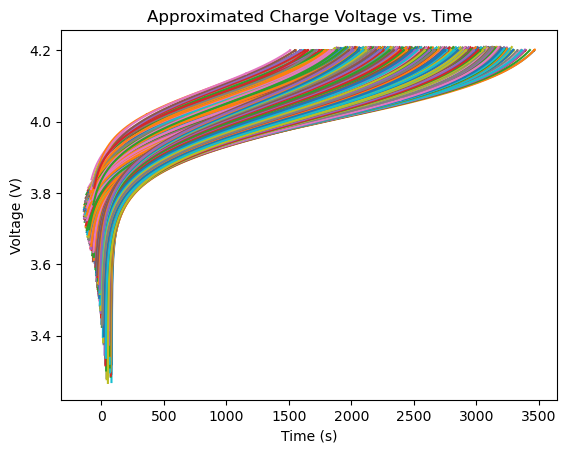

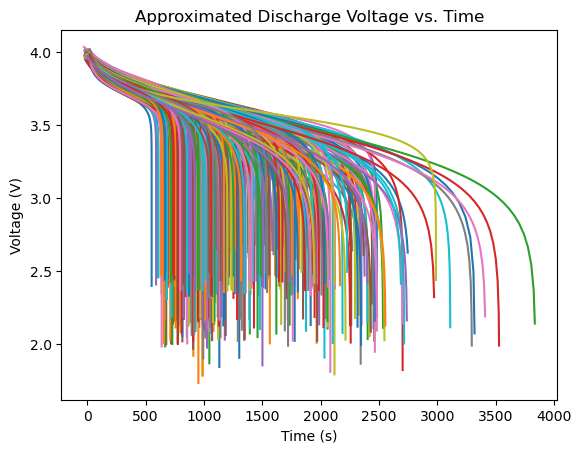

In [124]:
# define the sigmoid function
def sigmoid(X, L ,x0, k, b):
    y=[]
    for x in X:
        y.append(L / (1 + np.exp(-k*(x-x0)))+b)
    return y


# sigmoid function for the each charge cycle
fig, ax = plt.subplots()
for i in df_cycles.index:
    y_charge = np.array(df_cycles.loc[i]['charge_voltage_shape'])
    X_charge = sigmoid(y_charge, df_cycles.loc[i]['L_charge'], df_cycles.loc[i]['x0_charge'], 
                       df_cycles.loc[i]['k_charge'], df_cycles.loc[i]['b_charge'])
    ax.plot(X_charge, y_charge)
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Approximated Charge Voltage vs. Time')
plt.show()

# sigmoid function for the each simulated discharge cycle
fig, ax = plt.subplots()
for i in df_cycles.index:
    X_discharge = np.array(df_cycles.loc[i]['discharge_voltage'])
    y_discharge = sigmoid(X_discharge, df_cycles.loc[i]['L_discharge_sim'], df_cycles.loc[i]['x0_discharge_sim'], 
                          df_cycles.loc[i]['k_discharge_sim'], df_cycles.loc[i]['b_discharge_sim'])
    ax.plot(y_discharge, X_discharge)
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Approximated Discharge Voltage vs. Time')
plt.show()


 
0.1372 x + 3 [0.13724034 3.00026333]


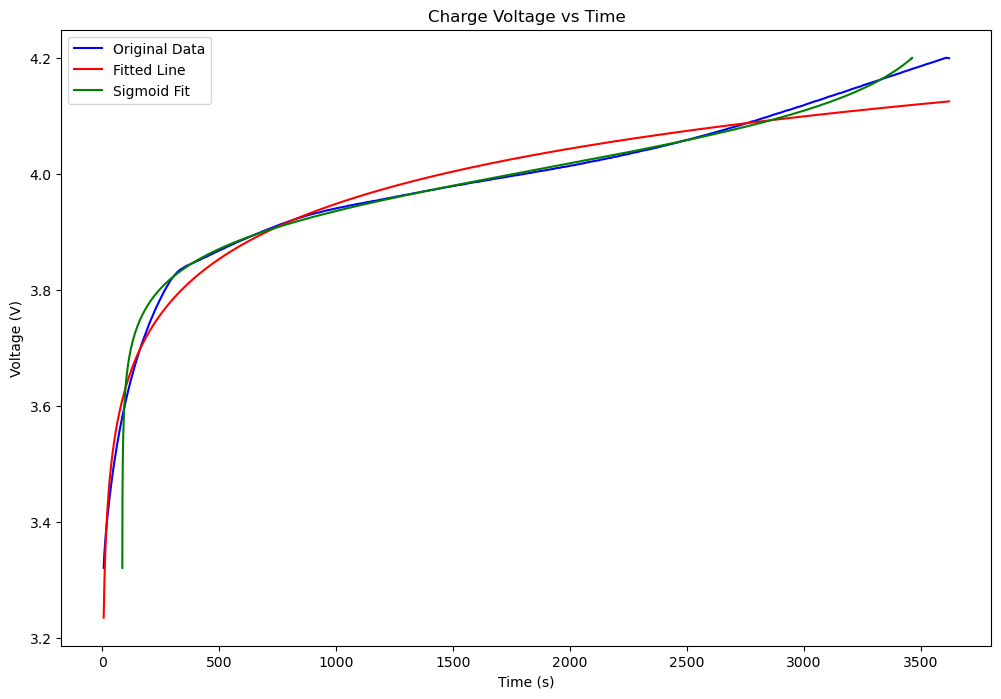

In [125]:
df_voltages = df_cycles[['charge_voltage_shape', 'charge_time', 'discharge_voltage', 'discharge_time']]
y_charge = df_voltages['charge_voltage_shape'].iloc[0]
X_charge = df_voltages['charge_time'].iloc[0][:len(y_charge)]

# get polynomial regression line for X_charge vs y_charge
X_charge = np.array(X_charge).reshape(-1,1)
# X_charge = np.log(X_charge)
transformer = preprocessing.FunctionTransformer(np.log, validate=True)
X_trans = transformer.fit_transform(X_charge)

# regressor = LinearRegression()
# results = regressor.fit(X_trans, y_charge)
# model = results.predict
# y_fit = model(X_trans)
y_charge = np.array(y_charge).reshape(-1,1)
z = np.polyfit(X_trans.flatten(), y_charge.flatten(), 1)
p = np.poly1d(z)
y_fit = p(X_trans)

print(p, z)

# attempt sigmoid fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

p0 = [max(X_charge.flatten()), np.median(y_charge.flatten()),1,min(X_charge.flatten())] 
popt, pcov = curve_fit(sigmoid, y_charge.flatten(), X_charge.flatten(), p0=p0, method='lm')

# new isgmoid funciton with popt
def generate_sigmoid(Y, popt):
    x=[]
    for i in range(len(Y)):
        x.append(sigmoid(Y[i], *popt))
    return x


X_fit_sig = generate_sigmoid(y_charge.flatten(), popt)

# print(y_fit)
# plot charge voltage vs time with polynomial regression line
plt.figure(figsize=(12,8))
plt.plot(X_charge, y_charge, color='blue', label='Original Data')
plt.plot(X_charge, y_fit, color='red', label='Fitted Logistic Line')
plt.plot(X_fit_sig, y_charge, color='green', label='Sigmoid Fit')
plt.title('Charge Voltage vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


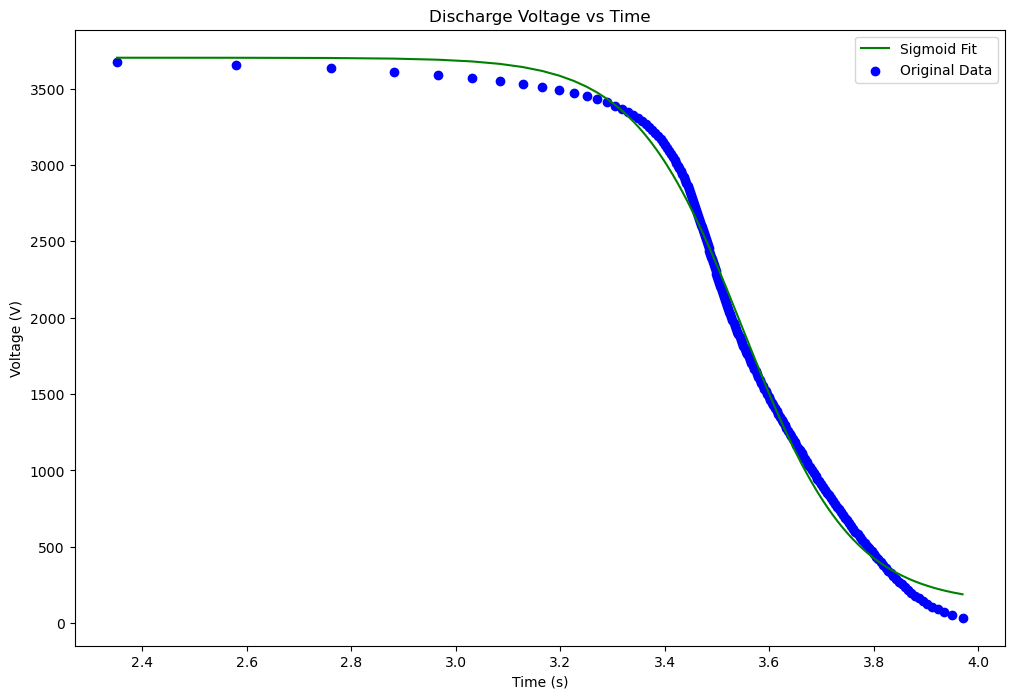

In [126]:
# for df_voltages plot discharge voltage vs time
X_discharge = df_voltages['discharge_voltage'].iloc[0]
y_discharge = df_voltages['discharge_time'].iloc[0]

# create np.polyfit for discharge voltage vs time
X_discharge = np.array(X_discharge).reshape(-1,1)
y_discharge = np.array(y_discharge).reshape(-1,1)

# attempt sigmoid fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

p0 = [max(y_discharge.flatten()), np.median(X_discharge.flatten()),1,min(y_discharge.flatten())] 
popt, pcov = curve_fit(sigmoid, X_discharge.flatten(), y_discharge.flatten(), p0=p0, method='lm')

# new isgmoid funciton with popt
def generate_sigmoid(X, popt):
    y=[]
    for i in range(len(X)):
        y.append(sigmoid(X[i], *popt))
    return y


y_sigmoid = generate_sigmoid(X_discharge.flatten(), popt)


plt.figure(figsize=(12,8))
plt.scatter(X_discharge, y_discharge, color='blue', label='Original Data')
plt.plot(X_discharge, y_sigmoid, color='green', label='Sigmoid Fit')
plt.title('Discharge Voltage vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()
                                            

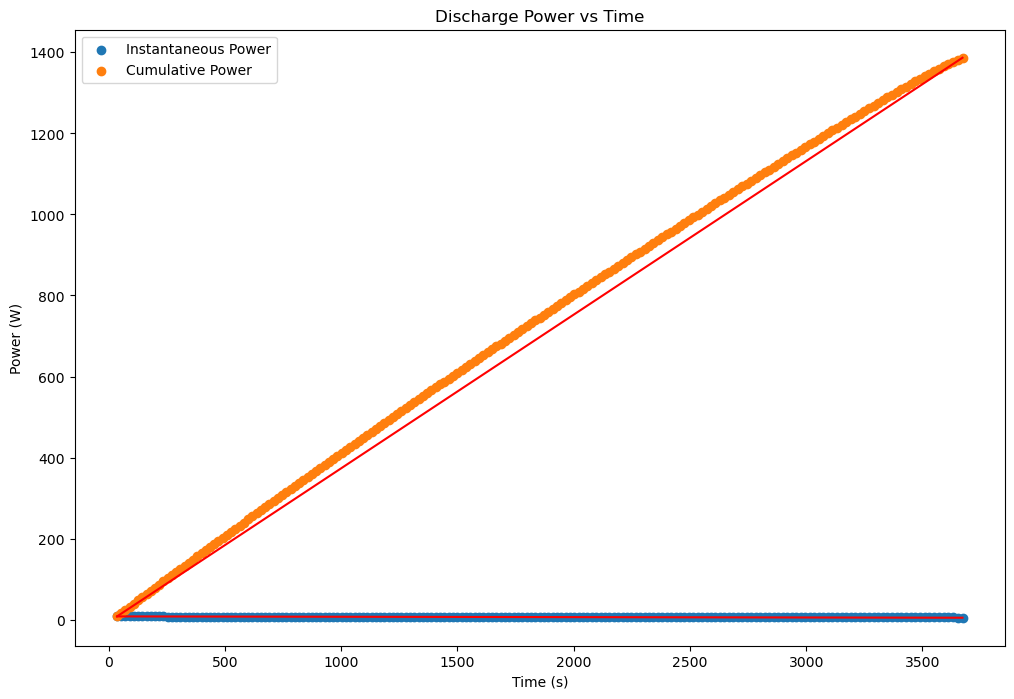

In [127]:
# look at power consumption over time 

# for first row, write variables for discharge characteristics
dis_current = np.array(df_cycles['discharge_current'].iloc[0])
dis_voltage = np.array(df_cycles['discharge_voltage'].iloc[0])
dis_time = np.array(df_cycles['discharge_time'].iloc[0])

dis_inst_power = dis_current * dis_voltage * -1
dis_cum_power = np.cumsum(dis_inst_power)
# inst_power and cum_power vs time 
plt.figure(figsize=(12,8))
plt.scatter(dis_time, dis_inst_power, label='Instantaneous Power')
plt.scatter(dis_time, dis_cum_power, label='Cumulative Power')
plt.plot([dis_time[0], dis_time[-1]], [dis_cum_power[0], dis_cum_power[-1]], color='red')
plt.plot([dis_time[0], dis_time[-1]], [dis_inst_power[0], dis_inst_power[-1]], color='red')
plt.title('Discharge Power vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

In [128]:
df_cycles['discharge_voltage_real'] = df_cycles['discharge_voltage'].copy()
df_cycles['discharge_time_real'] = df_cycles['discharge_time'].copy()

# create a simulation of real samples
np.random.seed(0)
charge_states = np.random.normal(40, 10, len(df_cycles))

In [136]:
# # write df_cycles to csv
df_cycles.to_csv('../Datasets/nasa/clean_cycles.csv', index=False)

# df_cycles_train, df_cycles_test = train_test_split(df_cycles, test_size=0.2)
# df_cycles_train.to_csv('../Datasets/nasa/clean_cycles_train.csv', index=False)
# df_cycles_test.to_csv('../Datasets/nasa/clean_cycles_test.csv', index=False)

# # read in train data for rest of notebook as df_cycles
# df_cycles = pd.read_csv('../Datasets/nasa/clean_cycles_train.csv')

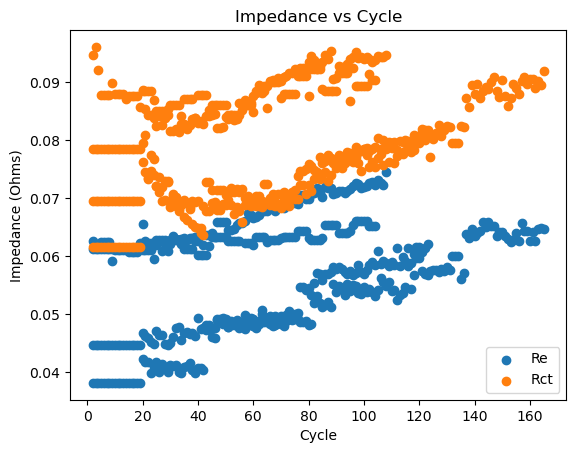

In [131]:
# scatter plot of Re and Rct vs cycle
fig, ax = plt.subplots()
ax.scatter(df_cycles['cycle'], df_cycles['Re'], label='Re')
ax.scatter(df_cycles['cycle'], df_cycles['Rct'], label='Rct')
ax.set_xlabel('Cycle')
ax.set_ylabel('Impedance (Ohms)')
ax.set_title('Impedance vs Cycle')
ax.legend()
plt.show()

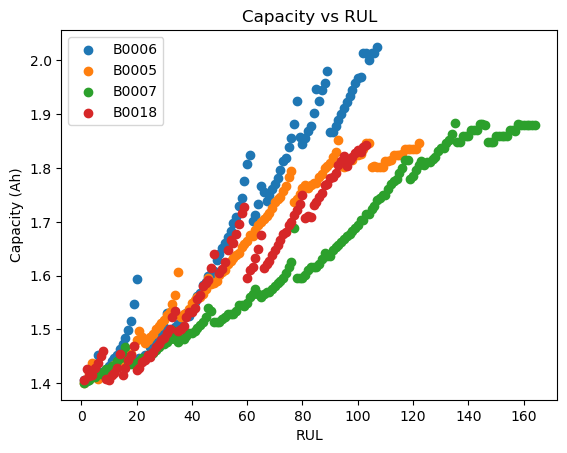

In [132]:
# capacity vs RUL for each battery
fig, ax = plt.subplots()
colors = ['r', 'y', 'g', 'b']
for batt in df_cycles['battery_id'].unique():
    df = df_cycles[df_cycles['battery_id'] == batt]
    ax.scatter(df['RUL'], df['capacity'], label=batt)
ax.set_xlabel('RUL')
ax.set_ylabel('Capacity (Ah)')
ax.set_title('Capacity vs RUL')
ax.legend()
plt.show()


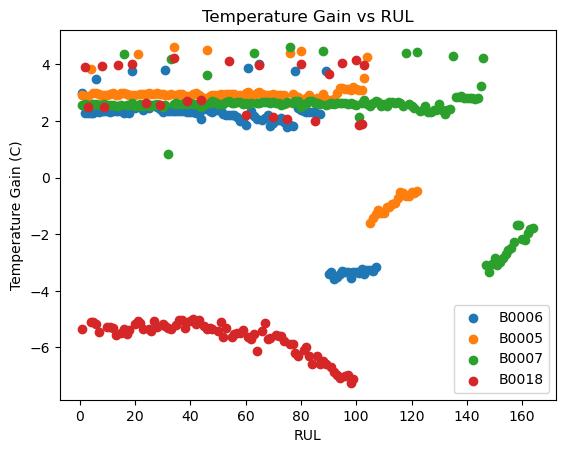

In [133]:
# charge_temp_gain vs RUL for each battery
fig, ax = plt.subplots()
colors = ['r', 'y', 'g', 'b']
for batt in df_cycles['battery_id'].unique():
    df = df_cycles[df_cycles['battery_id'] == batt]
    ax.scatter(df['RUL'], df['charge_temp_gain'], label=batt)
ax.set_xlabel('RUL')
ax.set_ylabel('Temperature Gain (C)')
ax.set_title('Temperature Gain vs RUL')
ax.legend()
plt.show()


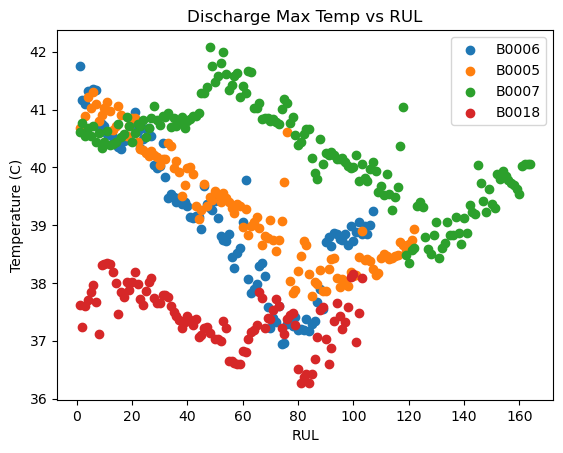

In [134]:
# discharge_max_temp vs RUL for each battery
fig, ax = plt.subplots()
colors = ['r', 'y', 'g', 'b']
for batt in df_cycles['battery_id'].unique():
    df = df_cycles[df_cycles['battery_id'] == batt]
    ax.scatter(df['RUL'], df['discharge_max_temp'], label=batt)
ax.set_xlabel('RUL')
ax.set_ylabel('Temperature (C)')
ax.set_title('Discharge Max Temp vs RUL')
ax.legend()
plt.show()

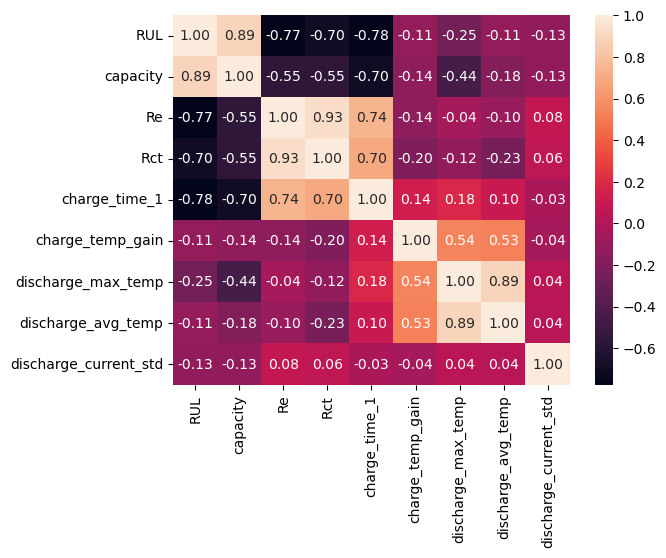

In [135]:
# USED FOR MIDTERM PPT
# reduce features in df_cycles to those included for modeling
df_model = df_cycles[['RUL', 'capacity', 'Re', 'Rct',  
                      'charge_time_1', 'charge_temp_gain', 'discharge_max_temp', 'discharge_avg_temp', 'discharge_current_std']]
df_model.head()
corr_matrix = df_model.corr()
corr_matrix
sn.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()